In [99]:
import amd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import collections
import pandas as pd
import pickle
import copy
import itertools
import pathlib
import cobra
import scipy

plot_format = "pdf"
# plot_format = "png"
# plot_format = "svg"
# plot_format = "tiff"
# plot_format = "eps"

plt.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = (
    r"\usepackage{amsmath}" 
    + r"\usepackage{siunitx}" 
    + r"\usepackage{lmodern}"
    + r"\sisetup{detect-all}"
    + r"\usepackage{sansmathfonts}"
)

plt.rcParams['savefig.dpi'] = 300
plt.rcParams["font.size"] = 14


In [100]:
with open("data/moma_colors.pickle", "rb") as f:
    moma_colors = pickle.load(f)

In [101]:
n = 1000
alpha=0.05

# select which of the three systems is calculated
# used_model, simplification = ("e_coli_core.json", "none")
used_model, simplification = ("iJO1366.json", "none")
# used_model, simplification = ("iJO1366.json", "FVA")

# this sets parameters for the matrix representation and the heatmap
# which are adapted for the size of the stoicheometric matrix
# min_size_level0 is the number of systems colored in matrix representation
# (limited by available colors as well)
# min_size_level1 set the minumin size for subsystems show in the heatmap
# size_named_subsystems is the minumum size for systems shown in the heatmap


if used_model == "e_coli_core.json":
    min_size_level0 = 5
    min_size_level1 = 5
    size_named_subsystems = 5
else:
    if simplification == "FVA":
        min_size_level0 = 10
        min_size_level1 = 10
        size_named_subsystems = 10
    else:
        min_size_level0 = 20
        min_size_level1 = 20
        size_named_subsystems = 50

plot_folder = f"plots/{used_model.split('.')[0]}_{simplification}/"

pathlib.Path(plot_folder).mkdir(parents=True, exist_ok=True)

In [102]:
path = pathlib.Path(".") / "models" / used_model
model = cobra.io.load_json_model(path)

S = cobra.util.array.create_stoichiometric_matrix(model, array_type="dok")


if simplification == "none":
    metabolites = model.metabolites
    reactions = model.reactions
    map = metabolites + reactions

In [103]:
if simplification == "glu":
    blocked = cobra.flux_analysis.variability.find_blocked_reactions(model)

    for k, v in S.items():
        S[k] = 1

    r_no = [i for i, x in enumerate(model.reactions) if x.id not in blocked]
    S = S[:, r_no]

    c_no = [i for i, x in enumerate(S.sum(1)) if x != 0]
    S = S[c_no, :]

    metabolites = [model.metabolites[i] for i in c_no]
    reactions = [model.reactions[i] for i in r_no]
    map = metabolites + reactions

In [104]:
if simplification == "FVA":
    df = cobra.flux_analysis.variability.flux_variability_analysis(model, loopless=True)

    df.to_csv("fva1.csv")

    df["abs"] = np.maximum(abs(df.maximum), abs(df.minimum))
    reactions_str = df.index[df["abs"] > 1e-10].tolist()

    with open("reactions1.txt", "w") as f:
        f.write("\n".join(reactions_str))

    for k, v in S.items():
        S[k] = 1

    r_no = [i for i, x in enumerate(model.reactions) if x.id in reactions_str]
    S = S[:, r_no]

    c_no = [i for i, x in enumerate(S.sum(1)) if x != 0]
    S = S[c_no, :]

    metabolites = [model.metabolites[i] for i in c_no]
    reactions = [model.reactions[i] for i in r_no]
    map = metabolites + reactions

In [105]:
r, c = S.shape
l = r + c
S_ = scipy.sparse.vstack(
    (
        scipy.sparse.hstack((scipy.sparse.dok_matrix((r, r)), S)),
        scipy.sparse.hstack((S.T, scipy.sparse.dok_matrix((c, c)))),
    )
)
S_ = scipy.sparse.csc_matrix(S_)
S_.data.fill(1)

In [106]:
S_

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 20366 stored elements and shape (4388, 4388)>

In [107]:
file = pathlib.Path(f"{plot_folder}/sub_count.pickle")
if file.is_file():
# if false:  # uncomment to force new calculation
    with open(file, "rb") as f:
        subs_count = pickle.load(f)
else:
    # change location where octove is installed
    subs, subs_count = amd.decompose_S_(S_, "~/.conda/envs/amd/bin/octave-cli", n)
    with open(file, "wb") as f:
        pickle.dump(subs_count, f)

In [108]:
subsystems, nested_subsystems = amd.identify_subsystems(
    subs_count, S_, n, alpha=alpha)

In [109]:
# [sorted([len(i) for i, v in subs_count.items() if v >= 59], reverse=True)]

In [110]:
s_interest = amd.get_systems_of_interest(nested_subsystems, l / 2)

o = set(range(S_.shape[0])) - set.union(*s_interest[1:])
o_reactions = [x for x in o if x > len(metabolites)]
len(o), len(o_reactions)

(653, 326)

In [111]:
systems_of_interest_with_subsystems = amd.get_systems_of_interest_with_subsystems(
    nested_subsystems, l / 2
)

In [112]:
systems_of_interest_one_sublevel = list()  # [system, subsystems, outer]
max_size_subsystems = max(l / 20, 20)
for s in systems_of_interest_with_subsystems:
    if len(s["system"]) <= max_size_subsystems:
        systems_of_interest_one_sublevel.append([s["system"], None, None])
    else:
        subsystems_plot = amd.get_systems_of_interest(s["sub"], max_size_subsystems)
        outer = s["system"] - set.union(*subsystems_plot)
        systems_of_interest_one_sublevel.append([s["system"], subsystems_plot, outer])

len(systems_of_interest_one_sublevel)

281

In [113]:
# systems_of_interest_two_sublevels = list()  # [system, subsystems, outer]
# max_sizes = [l / 4, l / 10, l/20]
# # max_size_level2 = l / 10
# # max_size_level3 = 99


# def get_largest_subs(system, all_systems, level, max_sizes):
#     if level > 2:
#         return None
#     max_size = max_sizes[level]
#     s = [x for x in all_systems if len(x) <= max_size if x < system]
#     subsystems = [x for x in s if np.all([not (x < y) for y in s])]
#     subsystems.sort(key=len, reverse=True)
#     res = list()
#     for sub in subsystems:
#         subsubs = get_largest_subs(sub, all_systems, level + 1, max_sizes)
#         # subsubs = [x for x in s if x < sub]
#         # # print(len(subsubs))
#         # subsubs.sort(key=len, reverse=True)
#         # subsubs = get_largest_subs(subsubs, max_size_level3)
#         res.append({"system": sub, "sub": subsubs})
#     return res


# # for s in systems_of_interest:
# #     systems_of_interest_two_sublevels.append(
# #         {"system": s, "sub": get_largest_subs(s, max_size_level2)}
# #     )
# subs_3_levels_hirarchical = get_largest_subs(set(range(l)), subsystems, 0, max_sizes)

# def uncoil_levels(s):
#     level1 = s["system"]
#     level2 = [x["system"] for x in s["sub"]]
#     level3 = [y["system"] for x in s["sub"] for y in x["sub"]]
#     return level1, level2, level3

# subs_3_levels = [uncoil_levels(s) for s in subs_3_levels_hirarchical]

In [114]:
subsystem_colors = [np.array(matplotlib.colors.to_rgb(x)) for x in moma_colors["Klein"]]

In [115]:
perm = amd.get_order(nested_subsystems, set(range(l)))

In [116]:
no_colored = len([x for x in s_interest if len(x) >= min_size_level0])
no_colored = min(no_colored, len(subsystem_colors) - 3)

def get_reactions(s):
    l = len(s)
    m = len([x for x in s if x < len(metabolites)])
    r = l - m
    return m, r


s10 = list()
s0 = list()


plot_systems = list()


for i, s in enumerate(systems_of_interest_one_sublevel[:no_colored]):
    subsub = list()
    color = subsystem_colors[i]
    m, r = get_reactions(s[0])
    label = f"system {i + 1} ({r} reactions, {m} metabolites)"
    if s[1] is not None:
        # smaller_subsustems.extend(s[1])
        for sub in s[1]:
            subsub.append({"label": None, "system": sub, "color": tuple(color)})
        color = color * 0.2 + np.array([1, 1, 1]) * 0.8
    plot_systems.append({"label": label, "system": s[0], "color": tuple(color)})
    plot_systems.extend(subsub)
    if s[1] is not None:
        plot_systems.append(
            {
                "label": f"subsystems system {i+1}",
                "system": {},
                "color": tuple(subsystem_colors[i]),
            }
        )


smaller_subsustems = [s[0] for s in systems_of_interest_one_sublevel[no_colored:]]
for s in smaller_subsustems:
    if len(s) > 10:
        color = subsystem_colors[no_colored + 1]
        s10.append(s)
    else:
        color = subsystem_colors[no_colored + 2]
        s0.append(s)
    plot_systems.append({"label": None, "system": s, "color": tuple(color)})


if len(s10) > 0:
    m, r = get_reactions(set.union(*s10))
    plot_systems.append(
        {
            "label": f"10 - {len(s_interest[no_colored])} elements ({r} reactions, {m} metabolites)",
            "system": {},
            "color": tuple(subsystem_colors[no_colored + 1]),
        }
    )

if len(s0) > 0:
    m, r = get_reactions(set.union(*s0))
    plot_systems.append(
        {
            "label": f"1 - {max([len(s) for s in s0])} elements ({r} reactions, {m} metabolites)",
            "system": {},
            "color": tuple(subsystem_colors[no_colored + 2]),
        }
    )

outer = set(range(l)) - set.union(*[s[0] for s in systems_of_interest_one_sublevel])
inner = set.union(*[s[0] for s in systems_of_interest_one_sublevel])
m, r = get_reactions(outer)
plot_systems.append(
    {
        "label": f"connectors ({r} reactions, {m} metabolites)",
        "system": outer,
        "color": (0.7, 0.7, 0.7),
    }
)

In [117]:
max([len(s) for s in s0])

10

In [118]:
no_colored

8

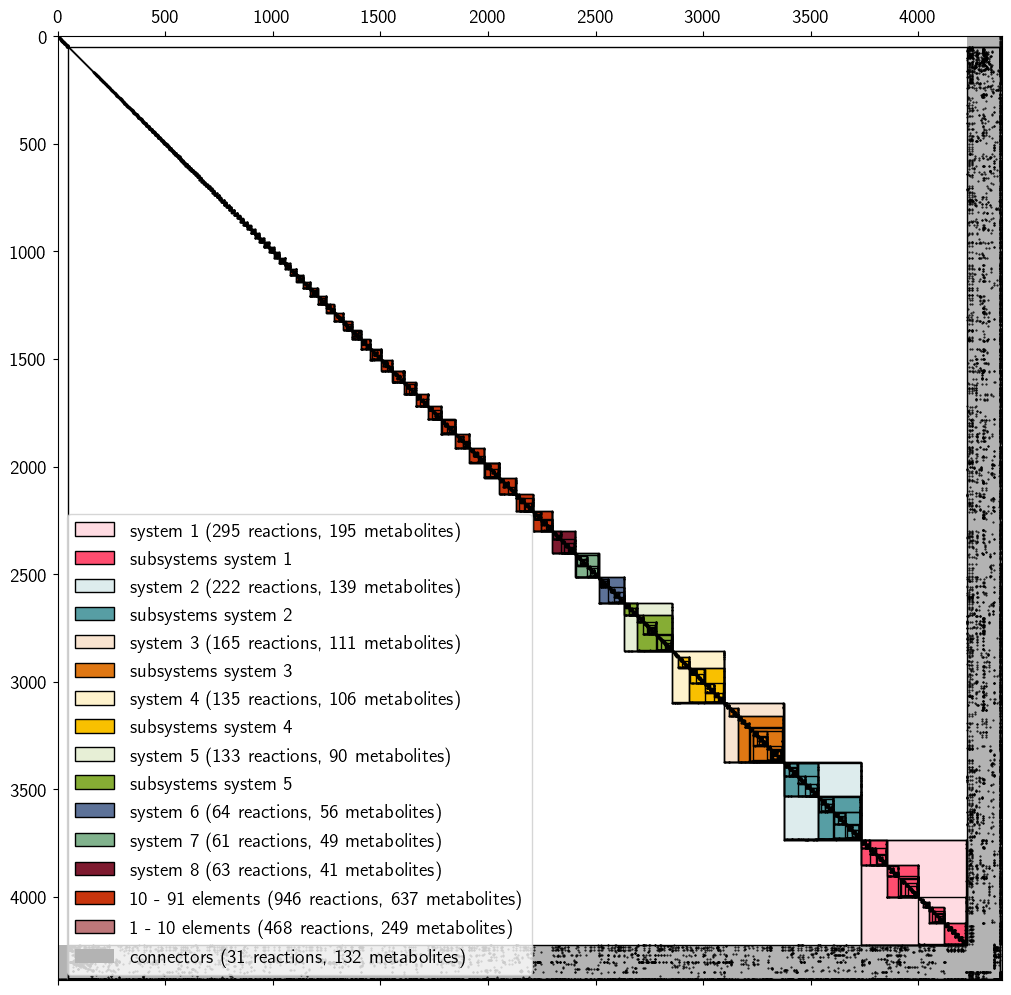

In [119]:
def plot_subsystems(
    S_,
    perm,
    subs,
    plot_systems,
    filename=None,
    markersize=1,
):

    # if systems_of_interest is None:
    #     subsystems = [x["system"] for x in subs]
    # else:
    #     subsystems = systems_of_interest
    # subsystems.sort(key=len, reverse=True)

    l = S_.shape[0]
    S_perm = S_[perm, :][:, perm]
    outer = plot_systems[-1]
    perm_inv = np.argsort(perm)

    fig, ax = plt.subplots(1, 1, figsize=(10, 10), layout="constrained")
    ax.invert_yaxis()

    c_edge = "k"
    linewidth = 1

    for x in plot_systems[:-1]:
        label = x["label"]
        system = sorted([perm_inv[a] for a in x["system"]])
        color = x["color"]
        s = len(system)
        if s == 0:
            lb = -0.5
        else:
            lb = system[0] - 0.5
        rainbow = matplotlib.patches.Rectangle(
            (lb, lb),
            s,
            s,
            facecolor=color,
            label=label,
            edgecolor=c_edge,
            linewidth=linewidth,
        )
        ax.add_patch(rainbow)

    outer = plot_systems[-1]["system"]
    outer_color = plot_systems[-1]["color"]
    outer_label = plot_systems[-1]["label"]
    for i, o in enumerate(outer):
        if i == 0:
            label = outer_label
        else:
            label = None
        x = perm_inv[o]
        p = matplotlib.patches.Polygon(
            [
                [-0.5, x + 0.5],
                [-0.5, x - 0.5],
                [x - 0.5, x - 0.5],
                [x - 0.5, -0.5],
                [x + 0.5, -0.5],
                [x + 0.5, x + 0.5],
            ],
            facecolor=outer_color,
            label=label,
        )
        ax.add_patch(p)

    # for smaller subsystem label
    # p = matplotlib.patches.Rectangle(
    #     (0, 0),
    #     0,
    #     0,
    #     facecolor=(1, 1, 1),
    #     label="smaller systems",
    #     edgecolor=c_edge,
    #     linewidth=linewidth,
    # )
    # ax.add_patch(p)

    s = copy.deepcopy(subs)
    c_edge = "k"
    linewidth = 1
    while s:
        x = s.pop()
        outer = None
        if len(x["sub"]) != 0:
            outer = x["system"] - set.union(*[y["system"] for y in x["sub"]])
            outer = sorted([perm_inv[x] for x in outer])
        inner = sorted([perm_inv[x] for x in x["system"]])
        s.extend(x["sub"])
        a = inner[0] - 0.5
        b = inner[-1] + 0.5
        r = matplotlib.patches.Rectangle(
            (a, a), b - a, b - a, fill=False, edgecolor=c_edge, linewidth=linewidth
        )
        ax.add_patch(r)
        # print(outer)
        if outer is not None:
            if len(outer) != 0:
                c = outer[0] - 0.5
                r = matplotlib.patches.Polygon(
                    [[a, c], [c, c], [c, a], [b, a], [b, b], [a, b]],
                    fill=False,
                    edgecolor=c_edge,
                    linewidth=linewidth,
                )
                ax.add_patch(r)

    # x, y = S_perm.nonzero()
    # ax.scatter(x, y, s=1, c="k", marker=".")
    ax.spy(S_perm, markersize=markersize, c="k", marker=".")
    # ax.set_xlim(0, l)
    # ax.set_ylim(l, 0)
    ax.legend(loc="lower left", bbox_to_anchor=(-0.00, -0.005))
    if filename is not None:
        plt.savefig(filename, bbox_inches="tight")
    plt.show()


plot_subsystems(
    S_, perm, nested_subsystems, plot_systems, filename=f"{plot_folder}matrix.{plot_format}"
)

In [120]:
def pickle_escher_data(
    plot_systems,
    model,
    perm,
    folder,
):
    reaction_data = dict()
    metabolite_data = dict()
    reaction_scale = list()
    perm_inv = np.argsort(perm)

    for i, x in enumerate(plot_systems):
        # system = sorted([perm_inv[a] for a in x["system"]])
        system = x["system"]
        c = x["color"]
        for x in system:
            if x < len(metabolites):
                metabolite_data[metabolites[x].id] = i
            else:
                reaction_data[reactions[x - len(metabolites)].id] = i

        reaction_scale.append(
            {
                "type": "value",
                "value": i,
                "color": f"rgb({c[0]*255}, {c[1]*255}, {c[2]*255})",
                "size": 20,
            }
        )
    i = len(plot_systems) 
    for r in [r for r in model.reactions if r not in reactions]:
        reaction_data[r.id] = i
    
    for m in [m for m in model.metabolites if m not in metabolites]:
        metabolite_data[m.id] = i

    reaction_scale.append(
        {
            "type": "value",
            "value": i,
            "color": f"rgb({0.9 * 255}, {0.9 * 255}, {0.9 * 255})",
            "size": 20,
        }
    )

    print(reaction_scale)
    with open(f"{plot_folder}reaction_data.pickle", "wb") as f:
        pickle.dump(reaction_data, f)

    with open(f"{plot_folder}metabolite_data.pickle", "wb") as f:
        pickle.dump(metabolite_data, f)

    with open(f"{plot_folder}reaction_scale.pickle", "wb") as f:
        pickle.dump(reaction_scale, f)


pickle_escher_data(plot_systems, model, perm, folder=plot_folder)

[{'type': 'value', 'value': 0, 'color': 'rgb(255.0, 219.4, 226.20000000000002)', 'size': 20}, {'type': 'value', 'value': 1, 'color': 'rgb(255.0, 77.0, 111.0)', 'size': 20}, {'type': 'value', 'value': 2, 'color': 'rgb(255.0, 77.0, 111.0)', 'size': 20}, {'type': 'value', 'value': 3, 'color': 'rgb(255.0, 77.0, 111.0)', 'size': 20}, {'type': 'value', 'value': 4, 'color': 'rgb(255.0, 77.0, 111.0)', 'size': 20}, {'type': 'value', 'value': 5, 'color': 'rgb(255.0, 77.0, 111.0)', 'size': 20}, {'type': 'value', 'value': 6, 'color': 'rgb(255.0, 77.0, 111.0)', 'size': 20}, {'type': 'value', 'value': 7, 'color': 'rgb(255.0, 77.0, 111.0)', 'size': 20}, {'type': 'value', 'value': 8, 'color': 'rgb(255.0, 77.0, 111.0)', 'size': 20}, {'type': 'value', 'value': 9, 'color': 'rgb(255.0, 77.0, 111.0)', 'size': 20}, {'type': 'value', 'value': 10, 'color': 'rgb(255.0, 77.0, 111.0)', 'size': 20}, {'type': 'value', 'value': 11, 'color': 'rgb(255.0, 77.0, 111.0)', 'size': 20}, {'type': 'value', 'value': 12, 'col

In [121]:
a = collections.Counter(subs_count.values())
b = sorted([(k, v) for k, v in a.items()], key=lambda x: x[0])
b = sorted([(i, a[i]) for i in range(1, n + 1)], key=lambda x: x[0])
print(b)
x = [i[0] for i in b]
y = [i[1] for i in b]
y_abs = [i * j for i, j in zip(x, y)]
y_rel = [i / sum(y_abs) * 100 for i in y_abs]

y_cum = np.cumsum(y_rel)
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 3), layout="constrained")
x_bins = np.array(range(0, n + 1, n // 10))
y_bins = [sum(y_rel[a : a + n // 10]) for a in x_bins]
# print(len(x), len(y), len(y_abs), len(list(zip(x, y))), len([i * j for i, j in zip(x, y)]))
ax0.bar(x_bins + 5 * n / 100, y_bins, width=n / 10)
# ax0.bar(x, y_rel, width=1)
# ax.set_yscale('log')
ax0.set_xlabel("occurance [% of decompositions]")
ax0.set_ylabel("% of found subsystems")

ax1.plot(x, y_cum)
ax1.set_xlabel("occurance [% of decompositions]")
ax1.set_ylabel("cummutalive distribution [%]")

x = [len(k) for k, v in subs_count.items()]
y = [v for k, v in subs_count.items()]
bins = np.linspace(0, n, 11)
size_groups = [0, 10, 100, 1000, 10000]
a = np.zeros((len(bins) - 1, len(size_groups) - 1))
for i in range(len(bins) - 1):
    s = [a for a, b in zip(x, y) if b > bins[i] if b <= bins[i + 1]]
    for j in range(len(size_groups) - 1):
        a[i, j] = len([x for x in s if x > size_groups[j] if x <= size_groups[j + 1]])
b = a / a.sum(axis=1, keepdims=True) * 100
# b = a

weight_count = {
    "$\leq$ 10": b[:, 0],
    "11 - 100": b[:, 1],
    "101 - 1000": b[:, 2],
    r"$>$ 1000": b[:, 3],
}
bottom = np.zeros(b.shape[0])
width = 10
for label, weight in weight_count.items():
    ax2.bar(np.linspace(5, 95, 10), weight, width, label=label, bottom=bottom)
    bottom += weight
ax2.legend(title="system size")
ax2.set_xlabel(r"occurance [\% of decompositions]")
ax2.set_ylabel(r"size distribution [\a%]")
ax2.set_xlim(0, 100)
# fig.savefig(f"plots/size_distribution.{plot_format}")

plt.show()

[(1, 2649), (2, 1158), (3, 497), (4, 508), (5, 449), (6, 222), (7, 244), (8, 281), (9, 252), (10, 190), (11, 181), (12, 119), (13, 79), (14, 42), (15, 157), (16, 45), (17, 46), (18, 83), (19, 39), (20, 145), (21, 76), (22, 80), (23, 69), (24, 65), (25, 44), (26, 51), (27, 44), (28, 35), (29, 14), (30, 17), (31, 17), (32, 19), (33, 26), (34, 12), (35, 24), (36, 19), (37, 10), (38, 15), (39, 6), (40, 5), (41, 35), (42, 12), (43, 17), (44, 12), (45, 3), (46, 6), (47, 5), (48, 19), (49, 25), (50, 1), (51, 2), (52, 6), (53, 3), (54, 33), (55, 14), (56, 11), (57, 3), (58, 6), (59, 3), (60, 7), (61, 7), (62, 1), (63, 8), (64, 2), (65, 8), (66, 10), (67, 1), (68, 9), (69, 1), (70, 8), (71, 8), (72, 2), (73, 9), (74, 3), (75, 3), (76, 3), (77, 0), (78, 5), (79, 1), (80, 1), (81, 0), (82, 1), (83, 2), (84, 16), (85, 7), (86, 4), (87, 3), (88, 18), (89, 1), (90, 2), (91, 3), (92, 3), (93, 5), (94, 1), (95, 0), (96, 2), (97, 0), (98, 2), (99, 7), (100, 4), (101, 2), (102, 0), (103, 1), (104, 2), (

<>:38: SyntaxWarning: invalid escape sequence '\l'
<>:38: SyntaxWarning: invalid escape sequence '\l'
/tmp/user/10021/ipykernel_2232251/399762677.py:38: SyntaxWarning: invalid escape sequence '\l'
  "$\leq$ 10": b[:, 0],


RuntimeError: latex was not able to process the following string:
b'size distribution [\\\\a%]'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmphjvoecms 1b43f58d583b6d22271f4a8ddb8f095b.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.24 (TeX Live 2022/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./1b43f58d583b6d22271f4a8ddb8f095b.tex
LaTeX2e <2022-11-01> patch level 1
L3 programming layer <2023-01-16>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2022/07/02 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsopn.sty))
(/usr/share/texlive/texmf-dist/tex/latex/siunitx/siunitx.sty
(/usr/share/texlive/texmf-dist/tex/latex/translations/translations.sty
(/usr/share/texlive/texmf-dist/tex/latex/etoolbox/etoolbox.sty)
(/usr/share/texlive/texmf-dist/tex/generic/pdftexcmds/pdftexcmds.sty
(/usr/share/texlive/texmf-dist/tex/generic/infwarerr/infwarerr.sty)
(/usr/share/texlive/texmf-dist/tex/generic/ltxcmds/ltxcmds.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/tools/array.sty))
(/usr/share/texmf/tex/latex/lm/lmodern.sty)
(/usr/share/texlive/texmf-dist/tex/latex/sansmathfonts/sansmathfonts.sty)
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texmf/tex/latex/lm/ot1lmr.fd)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 1b43f58d583b6d22271f4a8ddb8f095b.aux.
(/usr/share/texlive/texmf-dist/tex/latex/sansmathfonts/omlcmssm.fd)
(/usr/share/texlive/texmf-dist/tex/latex/sansmathfonts/omscmsssy.fd)
(/usr/share/texlive/texmf-dist/tex/latex/sansmathfonts/omxcmssex.fd)
(/usr/share/texlive/texmf-dist/tex/latex/sansmathfonts/uxcmss.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
(/usr/share/texlive/texmf-dist/tex/latex/graphics/color.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics-cfg/color.cfg)
(/usr/share/texlive/texmf-dist/tex/latex/graphics-def/dvips.def)
(/usr/share/texlive/texmf-dist/tex/latex/graphics/dvipsnam.def)
(/usr/share/texlive/texmf-dist/tex/latex/graphics/mathcolor.ltx))
(/usr/share/texlive/texmf-dist/tex/latex/translations/translations-basic-dictio
nary-english.trsl)
(/usr/share/texlive/texmf-dist/tex/latex/sansmathfonts/ot1xcmss.fd)

! LaTeX Error: Command \\end unavailable in encoding OT1.

See the LaTeX manual or LaTeX Companion for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.30 \end
         {document}
No pages of output.
Transcript written on tmphjvoecms/1b43f58d583b6d22271f4a8ddb8f095b.log.




<Figure size 1200x300 with 3 Axes>

In [122]:
x1 = [len(s) for s in subsystems]
y1 = [subs_count[tuple(sorted(s))] for s in subsystems]
x0 = [len(k) for k, v in subs_count.items()]
y0 = [v for k, v in subs_count.items()]


def plot_ax(x, y, ax, colors=moma_colors["Andri"]):
    bins = np.linspace(0, n, 11)
    size_groups = [0, 10, 100, 1000, 10000]
    a = np.zeros((len(bins) - 1, len(size_groups) - 1))
    for i in range(len(bins) - 1):
        s = [a for a, b in zip(x, y) if b > bins[i] if b <= bins[i + 1]]
        for j in range(len(size_groups) - 1):
            a[i, j] = len(
                [x for x in s if x > size_groups[j] if x <= size_groups[j + 1]]
            )

    b = a / a.sum(axis=1, keepdims=True) * 100
    b = a

    weight_count = {
        "$\leq$ 10": b[:, 0],
        "11 - 100": b[:, 1],
        "101 - 1000": b[:, 2],
        "> 1000": b[:, 3],
    }
    bottom = np.zeros(b.shape[0])

    width = 10
    for (label, weight), c in zip(weight_count.items(), colors):
        ax.bar(
            np.linspace(5, 95, 10), weight, width, label=label, bottom=bottom, color=c
        )
        bottom += weight
    ax.set_xlabel("occurance [% of decompositions]")
    ax.set_ylabel("no of unique subsystems")
    ax.set_xlim(0, 100)


# fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(8, 8), layout="constrained")
# plot_ax(x0, y0, ax0)
# plot_ax(x1, y1, ax1)
# [ax.set_ylim(1e1, 9500) for ax in (ax0, ax1)]
# # [ax.set_yscale("log") for ax in (ax0, ax1)]

# plot_ax(x0, y0, ax2)
# plot_ax(x1, y1, ax3)
# [ax.set_ylim(0, 250) for ax in (ax2, ax3)]
# ax1.set_ylabel(None)
# ax3.set_ylabel(None)
# ax0.set_xlabel(None)
# ax1.set_xlabel(None)
# ax0.legend()

# plt.show()

<>:22: SyntaxWarning: invalid escape sequence '\l'
<>:22: SyntaxWarning: invalid escape sequence '\l'
/tmp/user/10021/ipykernel_2232251/1415466635.py:22: SyntaxWarning: invalid escape sequence '\l'
  "$\leq$ 10": b[:, 0],


/tmp/user/10021/ipykernel_2232251/1415466635.py:18: RuntimeWarning: invalid value encountered in divide
  b = a / a.sum(axis=1, keepdims=True) * 100


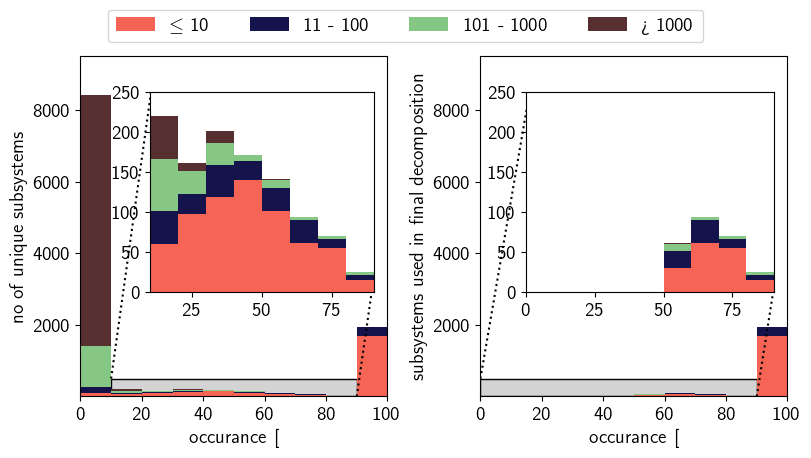

In [123]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4), layout="constrained")
rainbow = matplotlib.patches.Rectangle(
    (10, 0),
    80,
    500,
    alpha=1,
    facecolor="lightgrey",
    edgecolor="k",
    linestyle="-",
    linewidth=1,
)
ax0.add_patch(rainbow)

rainbow = matplotlib.patches.Rectangle(
    (0, 0),
    90,
    500,
    alpha=1,
    facecolor="lightgrey",
    edgecolor="k",
    linestyle="-",
    linewidth=1,
)
ax1.add_patch(rainbow)

plot_ax(x0, y0, ax0)
plot_ax(x1, y1, ax1)
[ax.set_ylim(1e1, 9500) for ax in (ax0, ax1)]
# [ax.set_yscale("log") for ax in (ax0, ax1)]
ax1.set_ylabel("subsystems used in final decomposition")
# ax0.legend()
ax01 = fig.add_axes(rect=(0.18, 0.4, 0.28, 0.5))
plot_ax(x0, y0, ax01)
ax01.set_ylim(0, 250)
ax01.set_xlabel(None)
ax01.set_ylabel(None)
ax01.set_xlim((10, 90))

ax11 = fig.add_axes(rect=(0.65, 0.4, 0.31, 0.5))
plot_ax(x1, y1, ax11)
ax11.set_ylim(0, 250)
ax11.set_xlabel(None)
ax11.set_ylabel(None)
ax11.set_xlim((0, 90))


ax0.plot((10, 23), (500, 8500), "k:")
ax0.plot((90, 95), (0, 3000), "k:")

ax1.plot((0, 16), (500, 8500), "k:")
ax1.plot((90, 95.5), (0, 3000), "k:")
# ax0.plot((10, 24), (0, 3000), "k:")
handles, labels = ax0.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="lower center",
    ncol=4,
    bbox_to_anchor=(0.5, 1),
    # title="system size",
)
# fig.savefig(f"plots/amd_count.{plot_format}", bbox_inches="tight")
plt.show()

In [124]:
pathway_names, pathway_reactions, dict_reaction_id_pathway, unused_kegg_reactions = (
    amd.load_kegg_info(
        "data/pathway_names_eco.pickle", "data/pathway_reactions_eco.pickle", model
    )
)

In [125]:
df = pd.read_csv("data/alt_clusters.csv")
alt_cluster_dict = dict(zip(df["ID"], df["cluster"]))
len(alt_cluster_dict)

248

In [126]:
# correct name difference to KEGG

corrected_reactions = {
    "_5DGLCNR": "5DGLCNR",
    "INDOLEt2pp_INDOLEt2rpp": "INDOLEt2rpp",
    "EX_glc_e": "EX_glc__D_e",
    "PPK2r": "PPK2",
    "PPKr": "PPK",
}

unknown_rections = list()
alt_cluster_dict_corr = dict()
for k, v in alt_cluster_dict.items():
    try:
        model.reactions.get_by_id(k)
        alt_cluster_dict_corr[k] = v
    except KeyError:
        try:
            model.reactions.get_by_id(k[:-3] + "_" + k[-3:])
            alt_cluster_dict_corr[k[:-3] + "_" + k[-3:]] = v
        except KeyError:
            try:
                model.reactions.get_by_id(corrected_reactions[k])
                alt_cluster_dict_corr[corrected_reactions[k]] = v
            except KeyError:
                unknown_rections.append(k)

In [127]:
# outer = set(range(l)) - set.union(*systems_of_interest)


def annotate_subsuystem(system, S_, outer):
    system_size = len(system)
    no_metabolites = 0
    no_rections = 0
    no_annotated_reactions = 0
    no_alt_annotated = 0
    pathways = collections.Counter()
    subsystems = collections.Counter()
    alt_annotations = collections.Counter()
    average_degree = S_[system, :].sum() / system_size
    connectors = S_[system, :].sum(axis=0).nonzero()[1]
    connectors = [x for x in connectors if x not in system]
    for i in system:
        if i < i_max_metabolites:
            no_metabolites += 1
        else:
            no_rections += 1
            reaction_no = i - i_max_metabolites
            subsystems.update([reactions[reaction_no].subsystem])
            if reaction_no in dict_reaction_id_pathway:
                no_annotated_reactions += 1
                pathways.update(dict_reaction_id_pathway[reaction_no])
            if reactions[reaction_no].id in alt_cluster_dict_corr:
                no_alt_annotated += 1
                alt_annotations.update(
                    [alt_cluster_dict_corr[reactions[reaction_no].id]]
                )

    return {
        "size": system_size,
        "no_metabolites": no_metabolites,
        "no_reactions": no_rections,
        "no_annotated_reactions": no_annotated_reactions,
        "no_alt_annotated": no_alt_annotated,
        "pathways": pathways,
        "subsystems": subsystems,
        "alt_annotations": alt_annotations,
        "average_degree": average_degree,
        "connectors": connectors,
    }


i_max_metabolites = len(metabolites)
system_information = dict()
for s in subsystems:
    system = tuple(sorted(s))
    system_information[system] = annotate_subsuystem(system, S_, outer)

outer_annotation = (
    tuple(sorted(outer)),
    annotate_subsuystem(tuple(sorted(outer)), S_, outer),
)

In [128]:
s = collections.Counter([x.subsystem for x in reactions])
subsystems_list = sorted(s.keys(), key=lambda x: s[x], reverse=True)

In [129]:
names_df = pd.read_csv("data/cluster_names.csv")
alt_cluster_names = dict(zip(names_df["Cluster #"], names_df["Pathway"]))

In [130]:
no_subsystems = 50
systems_of_interest = s_interest
subsystems_outer = sorted(systems_of_interest, key=len, reverse=True)
# named_subsystems = subsystems_outer[:no_subsystems]
named_subsystems = [s for s in subsystems_outer if len(s) >= size_named_subsystems]
if len(subsystems_outer) > no_subsystems:
    unnamed_subsystems = set.union(*subsystems_outer[no_subsystems:])
else:
    unnamed_subsystems = set()

data_pathways = np.zeros((len(named_subsystems) + 2, len(pathway_names)))
data_pathways_count = np.zeros((len(named_subsystems) + 2, len(pathway_names)))
data_subsystems = np.zeros((len(named_subsystems) + 2, len(subsystems_list) + 1))
data_alt_annotation = np.zeros(
    (len(named_subsystems) + 2, max(alt_cluster_dict.values()))
)
pathway_dict = dict(zip(pathway_names.keys(), range(len(pathway_names))))
subsystem_dict = dict(zip(subsystems_list, range(len(subsystems_list))))


for i, x in enumerate(named_subsystems + [unnamed_subsystems, outer]):
    system = tuple(sorted(x))
    annotation = annotate_subsuystem(system, S_, outer)
    for k, v in annotation["pathways"].items():
        data_pathways[i, pathway_dict[k]] = v
        data_pathways_count[i, pathway_dict[k]] = v
    for k, v in annotation["subsystems"].items():
        data_subsystems[i, subsystem_dict[k] + 1] = v
    data_subsystems[i, 0] = annotation["no_metabolites"]
    for k, v in annotation["alt_annotations"].items():
        data_alt_annotation[i, k - 1] = v

df_pathway = pd.DataFrame(
    data_pathways,
    index=[
        f"{i} ({j:.0f} / {k:.0f})"
        for i, j, k in zip(
            [f"subsystem {i}" for i in range(1, no_subsystems + 1)]
            + ["other subystems", "outer"],
            data_pathways_count.sum(1),
            data_subsystems.sum(1),
        )
    ],
    columns=[
        f"{pathway_names[x][:-31]} ({i:.0f})"
        for x, i in zip(pathway_names.keys(), data_pathways_count.sum(0))
    ],
)
df_pathway = df_pathway.iloc[:, data_pathways_count.sum(0).argsort()[::-1]]

df_subsystems = pd.DataFrame(
    data_subsystems,
    index=[
        f"subsystem{i} ({l:.0f})"
        for i, l in zip(
            list(range(1, no_subsystems + 1)) + ["other subystems", "outer"],
            data_subsystems.sum(1),
        )
    ],
    columns=[
        f"{x} ({l:.0f})"
        for x, l in zip(["metabolites"] + subsystems_list, data_subsystems.sum(0))
    ],
)

df_alt_annotation = pd.DataFrame(
    data_alt_annotation,
    index=[
        f"{i} ({l:.0f} / {k:.0f})"
        for i, l, k in zip(
            [f"subsystem {i}" for i in (range(1, no_subsystems + 1))]
            + ["other subystems", "outer"],
            data_alt_annotation.sum(1),
            data_subsystems.sum(1),
        )
    ],
    columns=[
        f"{alt_cluster_names[x + 1]} ({l:.0f})"
        for x, l in zip(range(len(alt_cluster_dict)), data_alt_annotation.sum(0))
    ],
)
df_alt_annotation = df_alt_annotation.iloc[
    :, data_alt_annotation.sum(0).argsort()[::-1]
]

In [131]:
subsystems_outer = sorted(systems_of_interest, key=len, reverse=True)
no_subsystems = len(subsystems_outer)

data_pathways_all = np.zeros((len(subsystems_outer) + 1, len(pathway_names)))
data_pathways_count_all = np.zeros((len(subsystems_outer) + 1, len(pathway_names)))
data_subsystems_all = np.zeros((len(subsystems_outer) + 1, len(subsystems_list) + 1))
data_alt_annotation_all = np.zeros(
    (len(subsystems_outer) + 1, max(alt_cluster_dict.values()))
)
pathway_dict_all = dict(zip(pathway_names.keys(), range(len(pathway_names))))
subsystem_dict_all = dict(zip(subsystems_list, range(len(subsystems_list))))

for i, x in enumerate(subsystems_outer + [outer]):
    system = tuple(sorted(x))
    annotation = annotate_subsuystem(system, S_, outer)
    for k, v in annotation["pathways"].items():
        data_pathways_all[i, pathway_dict[k]] = (
            v / annotation["no_annotated_reactions"] * 100
        )
        data_pathways_count_all[i, pathway_dict[k]] = v
    for k, v in annotation["subsystems"].items():
        data_subsystems_all[i, subsystem_dict[k] + 1] = v
    data_subsystems_all[i, 0] = annotation["no_metabolites"]
    for k, v in annotation["alt_annotations"].items():
        data_alt_annotation_all[i, k - 1] = v

df_pathway_all = pd.DataFrame(
    data_pathways_all,
    index=[
        f"{i} ({j:.0f} / {k:.0f})"
        for i, j, k in zip(
            [f"subsystem {i}" for i in range(1, no_subsystems + 1)] + ["connectors"],
            data_pathways_count_all.sum(1),
            data_subsystems_all.sum(1),
        )
    ],
    columns=[
        f"{pathway_names[x][:-31]} ({i:.0f})"
        for x, i in zip(pathway_names.keys(), data_pathways_count_all.sum(0))
    ],
)
df_pathway_all = df_pathway_all.iloc[:, data_pathways_count.sum(0).argsort()[::-1]]

df_subsystems_all = pd.DataFrame(
    data_subsystems_all,
    index=[f"subsystem {i}" for i in list(range(1, no_subsystems + 1))]
    + ["connectors"],
    columns=[f"{x}" for x in ["metabolites"] + subsystems_list],
)

df_alt_annotation_all = pd.DataFrame(
    data_alt_annotation_all,
    index=[f"subsystem {i}" for i in (range(1, no_subsystems + 1))] + ["connectors"],
    columns=[
        f"{alt_cluster_names[x + 1]}"
        for x, l in zip(range(len(alt_cluster_dict)), data_alt_annotation_all.sum(0))
    ],
)
df_alt_annotation_all = df_alt_annotation_all.iloc[
    :, data_alt_annotation_all.sum(0).argsort()[::-1]
]

In [132]:
# get heatmap data
system_names = list()
systems = list()
# no_systems_with_subsystem = no_colored
no_systems_with_subsystem = len([s for s in s_interest if len(s) >= size_named_subsystems])

no_subsystems = list()
for s in systems_of_interest_one_sublevel[:no_systems_with_subsystem]:
    x = s[1]
    if x is None:
        no_subsystems.append(0)
    else:
        no_subsystems.append(len([y for y in x if len(y) >= min_size_level1]))


for i, no_systems in enumerate(no_subsystems):
    if systems_of_interest_one_sublevel[i][1] is not None:
        system_names.extend([f"system {i + 1}.{j + 1}" for j in range(no_systems)])
        systems.extend(systems_of_interest_one_sublevel[i][1][:no_systems])
        if len(systems_of_interest_one_sublevel[i][1]) > no_systems:
            system_names.append(f"system {i + 1} smaller subsystems")
            systems.append(set.union(*systems_of_interest_one_sublevel[i][1][no_systems:]))
        system_names.append(f"system {i + 1} connectors")
        systems.append(systems_of_interest_one_sublevel[i][2])
    else:
        system_names.append(f"system {i + 1}")
        systems.append(systems_of_interest_one_sublevel[i][0])
# for i in range(no_systems_with_subsystem, no_colored):
#     system_names.append(f"system {i + 1}")
#     systems.append(systems_of_interest_one_sublevel[i][0])

systems10 = [x[0] for x in systems_of_interest_one_sublevel[i+1:] if len(x[0]) >= 10]
if len(systems10) > 0:
    system_names.append(f"smaller systems size 10 - {max([len(s) for s in systems10])}")
    systems.append(
        set.union(*systems10)
    )

systems0 = [x[0] for x in systems_of_interest_one_sublevel[i+1:] if len(x[0]) < 10]
system_names.append(f"smaller systems size 1 - {max([len(s) for s in systems0])}")
systems.append(
    set.union(*[x[0] for x in systems_of_interest_one_sublevel[no_colored:] if len(x[0]) < 10])
)
system_names.append("connectors")
systems.append(outer)

In [133]:
# get plot data with subsystems
def get_plot_data_with_subsystems(
    systems, system_names, pathway_names, subsystems_list, alt_cluster_dict, S_, outer
):
    data_pathways = np.zeros((len(systems), len(pathway_names)))
    data_pathways_count = np.zeros((len(systems), len(pathway_names)))
    data_subsystems = np.zeros((len(systems), len(subsystems_list) + 1))
    data_alt_annotation = np.zeros((len(systems), max(alt_cluster_dict.values())))
    pathway_dict = dict(zip(pathway_names.keys(), range(len(pathway_names))))
    subsystem_dict = dict(zip(subsystems_list, range(len(subsystems_list))))

    for i, x in enumerate(systems):
        system = tuple(sorted(x))
        annotation = annotate_subsuystem(system, S_, outer)
        for k, v in annotation["pathways"].items():
            data_pathways[i, pathway_dict[k]] = (
                v / annotation["no_annotated_reactions"] * 100
            )
            data_pathways_count[i, pathway_dict[k]] = v
        for k, v in annotation["subsystems"].items():
            data_subsystems[i, subsystem_dict[k] + 1] = v
        data_subsystems[i, 0] = annotation["no_metabolites"]
        for k, v in annotation["alt_annotations"].items():
            data_alt_annotation[i, k - 1] = v

    df_pathway = pd.DataFrame(
        data_pathways,
        index=system_names,
        columns=[
            f"{pathway_names[x][:-31]} ({i:.0f})"
            for x, i in zip(pathway_names.keys(), data_pathways_count_all.sum(0))
        ],
    )
    df_pathway = df_pathway.iloc[:, data_pathways_count.sum(0).argsort()[::-1]]

    df_subsystems = pd.DataFrame(
        data_subsystems,
        index=system_names,
        columns=[f"{x}" for x in ["metabolites"] + subsystems_list],
    )

    df_alt_annotation = pd.DataFrame(
        data_alt_annotation,
        index=system_names,
        columns=[
            f"{alt_cluster_names[x + 1]}"
            for x, l in zip(
                range(len(alt_cluster_dict)), data_alt_annotation_all.sum(0)
            )
        ],
    )
    df_alt_annotation = df_alt_annotation.iloc[
        :, data_alt_annotation.sum(0).argsort()[::-1]
    ]
    return df_pathway, df_subsystems, df_alt_annotation


df_pathway, df_subsystems, df_alt_annotation = get_plot_data_with_subsystems(
    systems, system_names, pathway_names, subsystems_list, alt_cluster_dict, S_, outer
)

In [134]:
# no_listed_systems = 8
# df0 = df_subsystems_all.T.copy()
# df = df0.iloc[:, :8].copy()

# df["size 50 - 99"] = df0.loc[:, (df0.sum(axis=0) < 100) & (df0.sum(axis=0) >= 50)].sum(
#     axis=1
# )
# df["size 10 - 49"] = df0.loc[:, (df0.sum(axis=0) < 50) & (df0.sum(axis=0) >= 10)].sum(
#     axis=1
# )
# df["size smaller 10"] = df0.loc[:, (df0.sum(axis=0) < 10)].sum(axis=1)
# df["connectors"] = df0.connectors
# df

In [135]:
def plot_heatmap(df, df_labels=None):
    df = df.loc[:, df.sum(axis=0) > 0].copy()
    fig, ax = plt.subplots(1, 1, figsize=(30, 20), layout="constrained")
    mask = np.zeros(df.shape)
    # for x in np.where(df.sum(axis=1).values == 0)[0]:
    #     df.iloc[x, :] = np.nan
    cmap = matplotlib.colormaps.get_cmap("Greys")
    cmap.set_bad(color="k")
    im = ax.imshow(df.T, cmap=cmap, vmin=0, vmax=100)
    ax.set_yticks(range(len(df.columns)), df.columns)
    ax.set_xticks(range(len(df.index)), df.index, rotation=90)
    cbar = plt.colorbar(
        im,
        location="right",
        fraction=0.01,
        aspect=50,
        label="distribution of named subsystems in dedected subsustems [%]",
        pad=0.01,
    )
    if df_labels is None:
        df_labels = df
    for (i, j), label in np.ndenumerate(df_labels):
        if label > 0:
            ax.text(i, j, f"{label:.0f}", ha="center", va="center", color="k")
    plt.show()


def plot_heatmap_abs(df, figsize=(30, 20)):
    df = df.loc[:, df.sum(axis=0) > 0].copy()
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    mask = np.zeros(df.shape)
    for x in np.where(df.sum(axis=1).values == 0)[0]:
        df.iloc[x, :] = np.nan
    cmap = matplotlib.colormaps.get_cmap("viridis")
    cmap.set_bad(color="k")
    im = ax.imshow(df.T, cmap=cmap)
    ax.set_yticks(range(len(df.columns)), df.columns)
    ax.set_xticks(range(len(df.index)), df.index, rotation=90)
    cbar = plt.colorbar(
        im,
        location="right",
        fraction=0.01,
        aspect=20,
        label="occurance",
        pad=0.01,
    )
    for (i, j), label in np.ndenumerate(df):
        if label > 0:
            ax.text(i, j, f"{label:.0f}", ha="center", va="center", color="k")

    plt.show()


# df = df_pathway.copy()
# # for i, c in enumerate(df.columns):
# #     data = df.iloc[:, i]
# #     df.iloc[i, :] = data / sum(data) * 100
# df = df.loc[(df.sum(axis=1) >= 5), :]
# plot_heatmap(df)

In [136]:
def plot_heatmap_bars_ax(
    ax,
    df,
    l_all,
    l_rev,
    l_alt,
    bar_scale_rows=1 / 50,
    bar_scale_columns=1 / 10,
    color_total="grey",
    color_rev="k",
    colormap="binary",
    bar_width=1,
    label_all="subsystem size (metabolite and reactions)",
    label_subset="reversible reactions",
    x_max=None,
    x_bar_no_space=1.2,
    c_bar_fraction=0.02,
    c_bar_aspect=30,
):
    df = df.loc[:, df.sum(axis=0) > 0].copy()
    if x_max is None:
        x_max = int(df.values.max())    
    cmap = plt.get_cmap(colormap, x_max + 1)
    im = ax.imshow(df.T, cmap=cmap, vmin=-0.5, vmax=x_max + 0.5)
    ax.set_yticks(range(len(df.columns)), df.columns)
    ax.set_xticks(range(len(df.index)), df.index, rotation=90)
    if x_max < 20:
        t = np.arange(0, x_max + 1)
    else:
        t = np.arange(0, x_max + 1, 5)

    cbar = plt.colorbar(
        im,
        location="bottom",
        fraction=c_bar_fraction,
        aspect=c_bar_aspect,
        label="Reaction count",
        pad=0.01,
        extend="max",
        ticks=t,
    )
    cbar.ax.tick_params(length=0)
    for (i, j), label in np.ndenumerate(df):
        if label > 0:
            if label > x_max * 0.5:
                ax.text(i, j, f"{label:.0f}", ha="center", va="center", color=cmap(0))
            else:
                ax.text(
                    i,
                    j,
                    f"{label:.0f}",
                    ha="center",
                    va="center",
                    color=cmap(df.values.max()),
                )

    max_high = 0
    for i, (all, rev) in enumerate(zip(l_all, l_rev)):
        total_hight = all * bar_scale_rows
        sub_hight = rev * bar_scale_rows
        max_high = max(max_high, total_hight)
        rainbow = matplotlib.patches.Rectangle(
            (-bar_width / 2 + i, -0.5 - total_hight),
            bar_width,
            total_hight,
            facecolor=color_total,
        )
        ax.add_patch(rainbow)
        ax.text(
            i,
            min(-total_hight - 0.8, -sub_hight - x_bar_no_space),
            f"{all:.0f}",
            ha="center",
            va="center",
            color=color_total,
        )
        rainbow = matplotlib.patches.Rectangle(
            (-bar_width / 2 + i, -0.5 - sub_hight),
            bar_width,
            sub_hight,
            facecolor=color_rev,
        )
        ax.add_patch(rainbow)
        ax.text(
            i, -sub_hight - 0.8, f"{rev:.0f}", ha="center", va="center", color=color_rev
        )

    ax.set_ylim(len(df.columns) - 0.5, -max_high * 1.2)

    x0 = len(df.index) - 0.5
    max_high = 0
    for j, alt in enumerate(l_alt):
        height = alt * bar_scale_columns
        max_high = max(max_high, height)
        rainbow = matplotlib.patches.Rectangle(
            (x0, -bar_width / 2 + j), height, bar_width, facecolor=color_rev
        )
        ax.add_patch(rainbow)
        ax.text(
            x0 + height + 0.6,
            j,
            f"{alt:.0f}",
            ha="center",
            va="center",
            color=color_rev,
        )
    rainbow = matplotlib.patches.Rectangle(
        (0, 0), 0, 0, facecolor=color_total, label=label_all
    )
    ax.add_patch(
        rainbow,
    )
    rainbow = matplotlib.patches.Rectangle(
        (0, 0),
        0,
        0,
        facecolor=color_rev,
        label=label_subset,
    )
    ax.add_patch(
        rainbow,
    )
    ax.set_xlim(-0.5, x0 + max_high * 1.4)
    ax.legend(loc="upper right", bbox_to_anchor=(0, 1))

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

    ax.tick_params(axis="both", which="both", length=0)


# def plot_heatmap_bars(
#     df,
#     l_all,
#     l_rev,
#     l_alt,
#     figsize=(15, 10),
#     bar_scale_rows=1 / 50,
#     bar_scale_columns=1 / 10,
#     color_total="grey",
#     color_rev="k",
#     colormap="binary",
#     bar_width=1,
#     label_all="subsystem size (metabolite and reactions)",
#     label_subset="reversible reactions",
#     x_max=None,
#     x_bar_no_space=1.2,
#     c_bar_fraction=0.02,
#     c_bar_aspect=30,
#     filename=None,
# ):
#     fig, ax = plt.subplots(1, 1, figsize=figsize, layout="constrained")
#     plot_heatmap_bars_ax(
#         ax,
#         df,
#         l_all,
#         l_rev,
#         l_alt,
#         bar_scale_rows,
#         bar_scale_columns,
#         color_total,
#         color_rev,
#         colormap,
#         bar_width,
#         label_all,
#         label_subset,
#         x_max,
#         x_bar_no_space,
#         c_bar_fraction,
#         c_bar_aspect,
#     )
#     if filename is not None:
#         plt.savefig(filename)
#     plt.show()


# df = df_alt_annotation_all.copy()
# l_all = data_subsystems_all.sum(1)
# l_rev = data_alt_annotation_all.sum(1)
# l_alt = data_alt_annotation_all.sum(0)
# l_alt = np.array(sorted(l_alt, reverse=True))
# df1 = df.loc[:, (df.sum(axis=0) > 2)]
# l_alt = l_alt[(df.sum(axis=0) > 2)]
# df = df1.loc[(df1.sum(axis=1) > 0), :]
# l_rev = l_rev[(df1.sum(axis=1) > 0)]
# l_all = l_all[(df1.sum(axis=1) > 0)]
# df = df.T
# df["smaller subsystems"] = df.iloc[:, 24:].sum(axis=1).values
# l_all = np.hstack((l_all[:24], [sum(l_all[24:])]))
# l_rev = np.hstack((l_rev[:24], [sum(l_rev[24:])]))
# df = df.T
# df.drop(labels=df.index[24:-1], inplace=True)
# plot_heatmap_bars(
#     df,
#     l_all,
#     l_rev,
#     l_alt,
#     bar_width=0.8,
#     figsize=(13, 10),
#     x_max=10,
#     c_bar_aspect=100,
#     c_bar_fraction=0.01,
#     filename=f"plots/reversible_reactions.{plot_format}",
# )

In [137]:
no_systems_with_subsystem, no_colored, len(subsystem_colors)

(21, 8, 11)

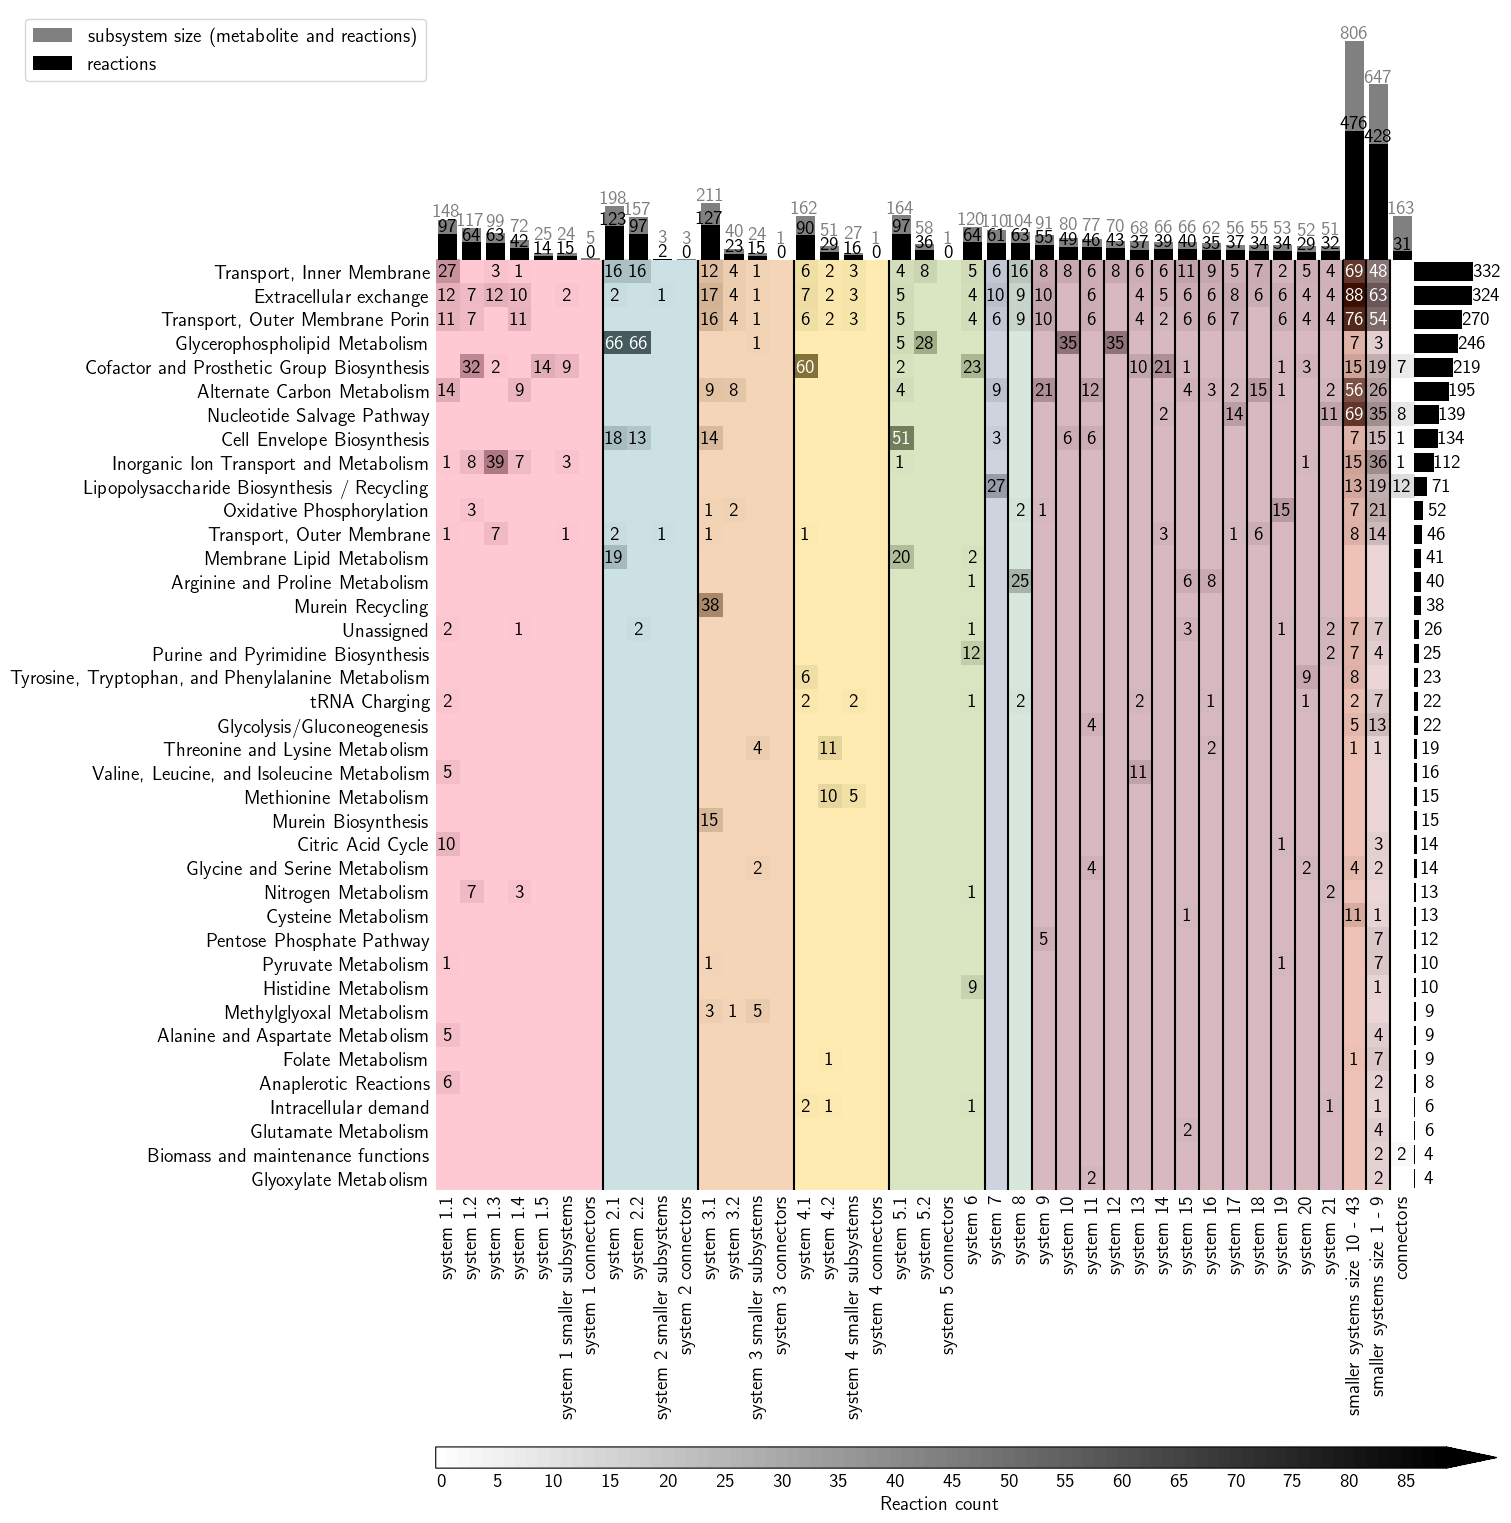

In [138]:
# no_subsystems = 337
df = df_subsystems.copy()
l_all = df_subsystems.values.sum(1)
l_rev = l_all - df_subsystems.values[:, 0]
l_alt = df_subsystems.values.sum(0)
l_alt = np.array(sorted(l_alt, reverse=True))
# df = df.T
# l_all = np.hstack((l_all[:no_subsystems], [sum(l_all[no_subsystems:-1])], [l_all[-1]]))
# l_rev = np.hstack((l_rev[:no_subsystems], [sum(l_rev[no_subsystems:-1])], [l_rev[-1]]))
# df = df.T
# df = df.loc[list(df.index[:-2]) + list(df.index[:-3:-1]), :]
# df.drop(labels=df.index[no_subsystems:-2], inplace=True)
df.drop(labels=df.columns[0], axis=1, inplace=True)
l_alt = l_alt[1:]
# plot_heatmap_bars(
#     df,
#     l_all,
#     l_rev,
#     l_alt,
#     bar_width=0.8,
#     bar_scale_columns=1 / 100 * l_rev[0] / l_all[0],
#     bar_scale_rows=1 / 100,
#     figsize=(15, 20),
#     label_all="subsystem size (metabolite and reactions)",
#     label_subset="reactions",
#     x_max=100,
#     c_bar_aspect=50,
#     c_bar_fraction=0.01,
#     filename=f"plots/annotated_subsustems.{plot_format}",
# )
fig, ax = plt.subplots(figsize=(15, 30), layout="constrained")
scale = min(100, int(np.array(df).max()))
alpha_background=0.3
plot_heatmap_bars_ax(
    ax,
    df,
    l_all,
    l_rev,
    l_alt,
    bar_width=0.8,
    bar_scale_columns=1 / scale * l_rev[0] / l_all[0],
    bar_scale_rows=1 / scale,
    label_all="subsystem size (metabolite and reactions)",
    label_subset="reactions",
    x_max=scale,
    c_bar_aspect=50,
    c_bar_fraction=0.01,
    x_bar_no_space=1.4,
)
sep_lines = list()
i = -0.5
for k, (x, c) in enumerate(zip(no_subsystems, subsystem_colors[:-3])):
    c = matplotlib.colors.to_rgba(c, alpha=alpha_background)
    if x > 0:
        if len(systems_of_interest_one_sublevel[k][1]) == no_subsystems:
            j = i + x + 1
        else:
            j = i + x + 2
        sep_lines.append(j)
    else:
        j = i + 1
        sep_lines.append(j)

    rainbow = matplotlib.patches.Rectangle(
        (i, -0.5),
        j - i,
        len(df.columns),
        facecolor=c,
    )
    ax.add_patch(rainbow)
    i = j

last_system = -2
if len(systems10) == 0:
    last_system = -1
for x in no_subsystems[k:last_system]: 
    sep_lines.append(i+1)
    rainbow = matplotlib.patches.Rectangle(
        (i, -0.5),
        1,
        len(df.columns),
        facecolor=c,
    )
    ax.add_patch(rainbow)
    i += 1

if len(systems10) > 0:
    rainbow = matplotlib.patches.Rectangle(
        (i, -0.5),
        1,
        len(df.columns),
        facecolor=matplotlib.colors.to_rgba(
            subsystem_colors[no_colored + 1], alpha=alpha_background
        ),
    )
    ax.add_patch(rainbow)
    i += 1
    sep_lines.append(i)

if len(s0) > 0:
    rainbow = matplotlib.patches.Rectangle(
        (i, -0.5),
        1,
        len(df.columns),
        facecolor=matplotlib.colors.to_rgba(
            subsystem_colors[no_colored + 2], alpha=alpha_background
        ),
    )
    ax.add_patch(rainbow)
    i += 1
    sep_lines.append(i)

# rainbow = matplotlib.patches.Rectangle(
#     (i, -0.5),
#     1,
#     len(df.columns),
#     facecolor=(0.9, 0.9, 0.9),
# )
# ax.add_patch(rainbow)


ax.vlines(x=sep_lines, ymin=-0.5, ymax=len(df.columns), colors="k")
plt.savefig(f"{plot_folder}annotated_subsustems.{plot_format}", bbox_inches="tight")
plt.show()

In [139]:
x = df_subsystems_all.loc[:, "Glycolysis/Gluconeogenesis"]
x = x[x > 0]
y = df_subsystems_all.sum(axis=1).loc[x.index]
z = df_subsystems_all.loc[x.index, df_subsystems.columns[0]]
pd.DataFrame({"in subsystem": x, "total reactions": y - z, "system size": y})

,in subsystem,total reactions,system size
subsystem 11,4.0,46.0,77.0
subsystem 31,1.0,19.0,29.0
subsystem 45,3.0,8.0,12.0
subsystem 57,1.0,6.0,10.0
subsystem 65,6.0,6.0,9.0
subsystem 187,1.0,1.0,1.0
subsystem 188,1.0,1.0,1.0
subsystem 189,1.0,1.0,1.0
subsystem 190,1.0,1.0,1.0
subsystem 248,1.0,1.0,1.0


In [140]:
x = df_subsystems_all.loc[:, "Citric Acid Cycle"]
x = x[x > 0]
y = df_subsystems_all.sum(axis=1).loc[x.index]
z = df_subsystems_all.loc[x.index, df_subsystems.columns[0]]
pd.DataFrame({"in subsystem": x, "total reactions": y - z, "system size": y})

,in subsystem,total reactions,system size
subsystem 1,10.0,295.0,490.0
subsystem 19,1.0,34.0,53.0
subsystem 228,1.0,1.0,1.0
subsystem 239,1.0,1.0,1.0
subsystem 240,1.0,1.0,1.0


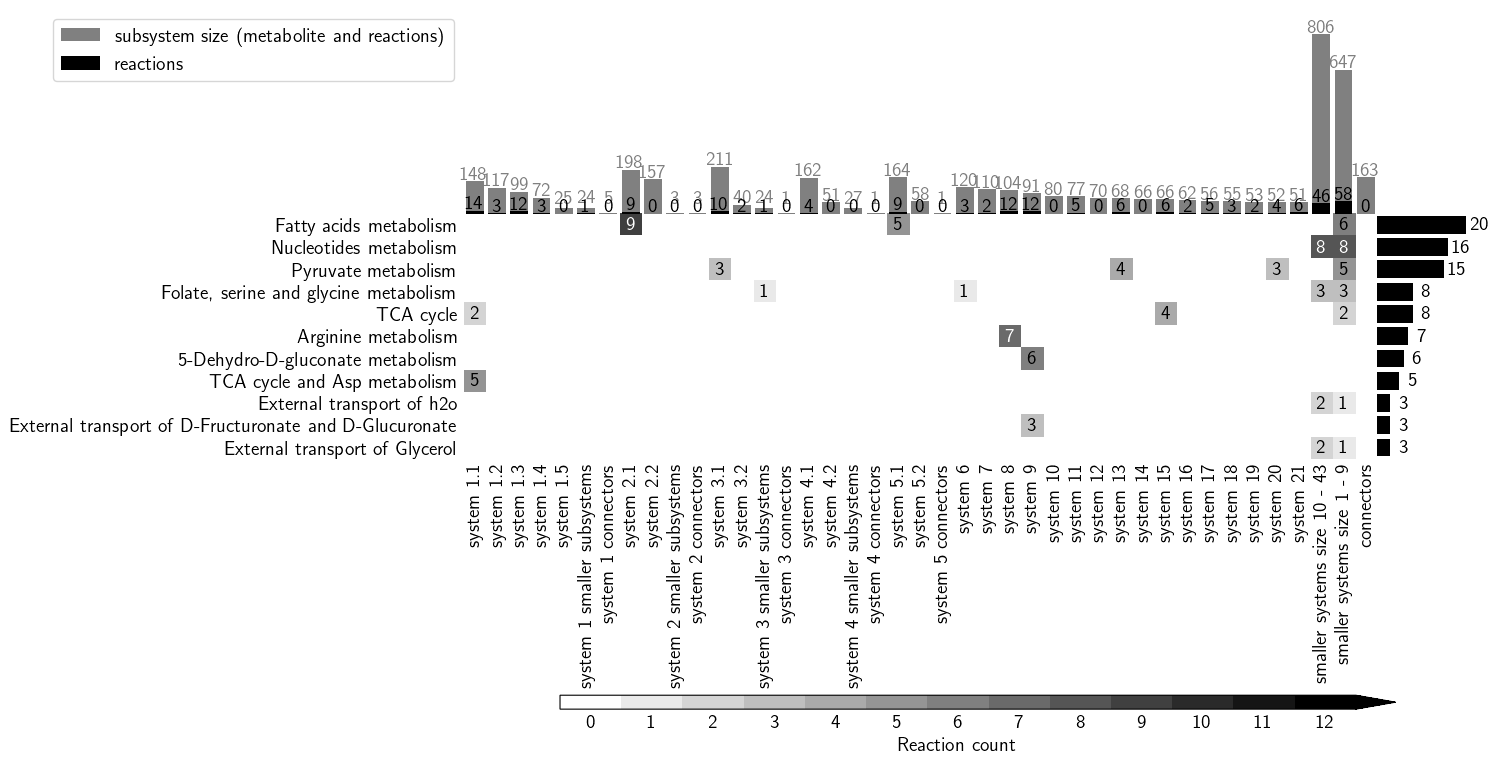

In [141]:
df = df_alt_annotation.copy()
l_all = df_subsystems.values.sum(1)
l_rev = df_alt_annotation.values.sum(1)
l_alt = df_alt_annotation.values.sum(0)
l_alt = np.array(sorted(l_alt, reverse=True))
df.drop(labels=df.columns[0], axis=1, inplace=True)
l_alt = l_alt[1:12]

fig, ax = plt.subplots(figsize=(15, 10), layout="constrained")
plot_heatmap_bars_ax(
    ax,
    df.iloc[:, :11],
    l_all,
    l_rev,
    l_alt,
    bar_width=0.8,
    bar_scale_columns=1 / 5,
    bar_scale_rows=1 / 100,
    label_all="subsystem size (metabolite and reactions)",
    label_subset="reactions",
    x_max=12,
    c_bar_aspect=60,
    c_bar_fraction=0.02,
)
# ax.vlines(
#     x=(4.5, 11.5, 15.5, 18.5, 19.5, 21.5), ymin=-0.5, ymax=len(df.columns), colors="k"
# )
# plt.savefig(f"plots/annotated_subsustems.{plot_format}")
plt.show()

In [142]:
outer_annotation[1]["average_degree"]

np.float64(36.29447852760736)

In [143]:
degrees = np.array(S_.sum(axis=0))[0]
outer_degrees = degrees[np.array(sorted(outer))]
inner_degrees = degrees[np.array(sorted(inner))]


# fig, ax = plt.subplots(figsize=(8, 5), layout="constrained")
# ax.hist(
#     inner_degrees,
#     bins=range(0, 1100, 10),
#     alpha=0.5,
#     label="subsystems",
#     weights=[1 / inner_degrees.shape[0]] * inner_degrees.shape[0],
# )
# ax.hist(
#     outer_degrees,
#     bins=range(0, 1100, 10),
#     alpha=0.5,
#     label="connectors",
#     weights=[1 / outer_degrees.shape[0]] * outer_degrees.shape[0],
# )
# # ax.set_xscale('log')
# # ax.set_yscale('log')
# ax.legend()
# ax.set_xlabel("Degree")
# ax.set_ylabel("Frequency (binsize = 10)")
# plt.show()

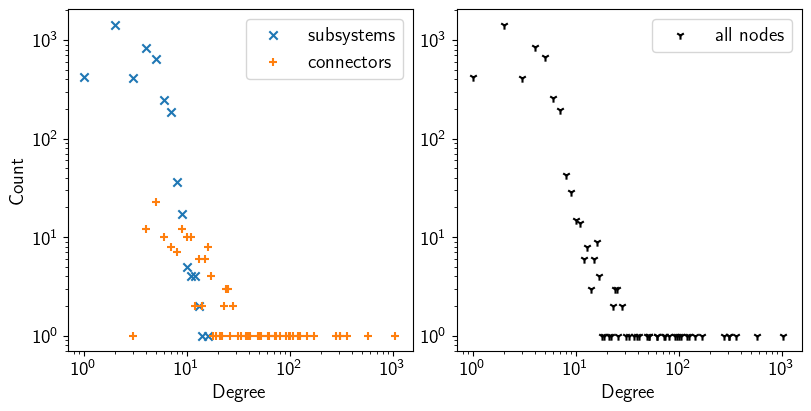

In [144]:
inner_degree_count = np.zeros(1100)
outer_degree_count = np.zeros(1100)
degree_count = np.zeros(1100)
for i in inner_degrees.astype(int):
    inner_degree_count[i] += 1
    degree_count[i] += 1
for i in outer_degrees.astype(int):
    outer_degree_count[i] += 1
    degree_count[i] += 1

# inner_degree_count = inner_degree_count / np.sum(inner_degree_count)
# outer_degree_count = outer_degree_count / np.sum(outer_degree_count)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4), layout="constrained")
# ax.plot(degree_count, label="total")
# ax.plot(inner_degree_count, label="subsystems")
# ax.plot(outer_degree_count, label="connectors")
# ax.scatter(np.arange(len(degree_count)), degree_count, label="total", marker=".")
ax0.scatter(
    np.arange(len(inner_degree_count)),
    inner_degree_count,
    label="subsystems",
    marker="x",
)
ax0.scatter(
    np.arange(len(outer_degree_count)),
    outer_degree_count,
    label="connectors",
    marker="+",
)
ax0.set_xscale("log")
ax0.set_yscale("log")
# ax.set_xlim(0, 1e2)
ax0.legend()
ax0.set_xlabel("Degree")
ax0.set_ylabel("Count")

ax1.scatter(
    np.arange(len(degree_count)), degree_count, label="all nodes", marker="1", c="k"
)
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("Degree")
ax1.legend()
# plt.savefig(f"{plot_folder}degree_distribution.{plot_format}")
plt.show()

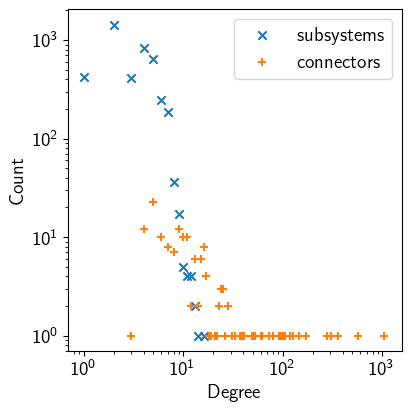

In [145]:
fig, ax0 = plt.subplots(1, 1, figsize=(4, 4), layout="constrained")
ax0.scatter(
    np.arange(len(inner_degree_count)),
    inner_degree_count,
    label="subsystems",
    marker="x",
)
ax0.scatter(
    np.arange(len(outer_degree_count)),
    outer_degree_count,
    label="connectors",
    marker="+",
)
ax0.set_xscale("log")
ax0.set_yscale("log")
# ax.set_xlim(0, 1e2)
ax0.legend()
ax0.set_xlabel("Degree")
ax0.set_ylabel("Count")
plt.savefig(f"{plot_folder}degree_distribution.{plot_format}")
plt.show()

In [146]:
superconnectors = set([x for x, d in zip(sorted(outer), outer_degrees) if d > 10])
# [model.metabolites[i].reactions for i in superconnectors]
len(superconnectors)

80

In [147]:
len(outer_degrees)

163

In [157]:
sorted(
    zip(
        [
            (metabolites[i].name, metabolites[i].id)
            for i in sorted(outer)
            if i < len(metabolites)
        ],
        outer_degrees,
    ),
    key=lambda x: x[1],
    reverse=True,
)[-20:]

[(('Glutaredoxin (oxidized)', 'grxox_c'), np.float64(6.0)),
 (('Glutaredoxin (reduced)', 'grxrd_c'), np.float64(6.0)),
 (('Guanine', 'gua_c'), np.float64(6.0)),
 (('UDP-N-acetyl-D-glucosamine', 'uacgam_c'), np.float64(6.0)),
 (('Undecaprenyl diphosphate', 'udcpdp_c'), np.float64(6.0)),
 (('Core oligosaccharide lipid A', 'colipa_p'), np.float64(6.0)),
 (('Meso-2,6-Diaminoheptanedioate', '26dap__M_c'), np.float64(5.0)),
 (('Carbamoyl phosphate', 'cbp_c'), np.float64(5.0)),
 (('DTMP C10H13N2O8P', 'dtmp_c'), np.float64(5.0)),
 (('Deoxyuridine', 'duri_c'), np.float64(5.0)),
 (('D-Erythrose 4-phosphate', 'e4p_c'), np.float64(5.0)),
 (('D-Xylulose 5-phosphate', 'xu5p__D_c'), np.float64(5.0)),
 (('D-Ribulose 5-phosphate', 'ru5p__D_c'), np.float64(5.0)),
 (('Undecaprenyl phosphate', 'udcpp_c'), np.float64(5.0)),
 (('(R)-3-Hydroxytetradecanoyl-[acyl-carrier protein]', '3hmrsACP_c'),
  np.float64(4.0)),
 (('Decanoyl-CoA (n-C10:0CoA)', 'dcacoa_c'), np.float64(4.0)),
 (('DUMP C9H11N2O8P', 'dump_c')

In [158]:
sorted(
    zip(
        [
            reactions[i - len(metabolites)].name
            for i in sorted(outer)
            if i >= len(metabolites)
        ],
        outer_degrees,
    ),
    key=lambda x: x[1],
    reverse=True,
)[:-10]

[("5'-nucleotidase (dCMP)", np.float64(359.0)),
 ('Deoxyuridine kinase (ATP:Deoxyuridine)', np.float64(277.0)),
 ('6-hydroxymethyl-dihydropterin pyrophosphokinase', np.float64(91.0)),
 ('E. coli biomass objective function (iJO1366) - core - with 53.95 GAM estimate',
  np.float64(61.0)),
 ('Dihydrofolate reductase', np.float64(37.0)),
 ('Nucleoside-diphosphate kinase (ATP:dUDP)', np.float64(33.0)),
 ('Lipoate synthase', np.float64(28.0)),
 ('3-deoxy-D-manno-octulosonic acid transferase', np.float64(25.0)),
 ('D-glycero-D-manno-hepose 1-phosphate adenyltransferase', np.float64(24.0)),
 ('3-deoxy-D-manno-octulosonic acid transferase III (LPS core biosynthesis)',
  np.float64(24.0)),
 ('Heptosyltransferase IV (LPS core synthesis)', np.float64(21.0)),
 ('3-deoxy-manno-octulosonate cytidylyltransferase', np.float64(18.0)),
 ('Heptosyltransferase I (LPS core synthesis)', np.float64(17.0)),
 ('Biotin synthase', np.float64(16.0)),
 ('Lipid A transport via ABC system (periplasm to extracellular)

In [159]:
sorted(
    zip(
        [
            (metabolites[i].name, metabolites[i].id)
            for i in sorted(inner)
            if i < len(metabolites)
        ],
        inner_degrees,
    ),
    key=lambda x: x[1],
    reverse=True,
)[:10]

[(('L-Methionine', 'met__L_c'), np.float64(16.0)),
 (('2-Demethylmenaquinol 8', '2dmmql8_c'), np.float64(14.0)),
 (('Oxaloacetate', 'oaa_c'), np.float64(13.0)),
 (('D-Alanine', 'ala__D_p'), np.float64(13.0)),
 (('L-Malate', 'mal__L_c'), np.float64(12.0)),
 (('Riboflavin C17H20N4O6', 'ribflv_c'), np.float64(12.0)),
 (('2-Demethylmenaquinone 8', '2dmmq8_c'), np.float64(11.0)),
 (('Dodecanoate (n-C12:0)', 'ddca_p'), np.float64(11.0)),
 (('Octadecanoate (n-C18:0)', 'ocdca_p'), np.float64(11.0)),
 (('Tetradecanoate (n-C14:0)', 'ttdca_p'), np.float64(11.0))]

In [160]:
[
    x
    for x in sorted(
        zip(
            range(len(inner)),
            [
                (
                    reactions[i - len(metabolites)].name,
                    reactions[i - len(metabolites)].id,
                )
                for i in sorted(inner)
            ],
            inner_degrees,
        ),
        key=lambda x: x[2],
        reverse=True,
    )
    if x[0] >= len(metabolites)
][:10]

[(3874, ('SUF [2Fe-2S] Synthesis', 'S2FE2SS'), np.float64(12.0)),
 (3875, ('SUF [2Fe-2S] Synthesis II', 'S2FE2SS2'), np.float64(12.0)),
 (3873, ('SUF [2Fe-2S] regeneration', 'S2FE2SR'), np.float64(10.0)),
 (2327,
  ('Asparagine synthase (glutamine-hydrolysing)', 'ASNS1'),
  np.float64(9.0)),
 (2378,
  ('Carbamoyl-phosphate synthase (glutamine-hydrolysing)', 'CBPS'),
  np.float64(9.0)),
 (2570, ('CTP synthase (glutamine)', 'CTPS2'), np.float64(9.0)),
 (3101, ('GMP synthase', 'GMPS2'), np.float64(9.0)),
 (3668,
  ('2-Octaprenyl-3-methyl-6-methoxy-1,4-benzoquinol hydroxylase (anaerobic)',
   'OMMBLHX3'),
  np.float64(9.0)),
 (3676,
  ('2-octaprenyl-6-methoxyphenol hydroxylase (anaerobic)', 'OMPHHX3'),
  np.float64(9.0)),
 (3683, ("Pyridoxine 5'-phosphate synthase", 'PDX5PS'), np.float64(9.0))]

In [154]:
n = 1000
alpha = 0.05
i = n // 2
while scipy.stats.binomtest(i, n, p=0.5, alternative="greater").pvalue > alpha:
    i += 1
i

527